In [17]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드
data = pd.read_csv('data/All_not_null/55285839-9b78-48d8-9f4e-573190ace016_data.csv')

# 2. null값 처리
data = data.dropna() 

# 데이터의 시간 정보를 사용하여 훈련과 테스트 데이터 나누기
# 여기서는 'created_at' 컬럼을 기준으로 시계열을 정렬
data['created_at'] = pd.to_datetime(data['created_at'], unit='s')
data = data.sort_values(by='created_at')
target = data['imbalance_health'].apply(lambda x: 1 if x == 1 else 0)

# 3. 필요한 열 선택 (라벨 및 불필요한 열 제외)
data = data.drop(columns=['asset_id', 'created_at', 'created_at_datetime', 'temperature', 'looseness_health', 'time','misalignment_health', 'asset_health', 'bearing_health', 'imbalance_health'])
# data = data.loc[:,['vel_crest_factor_x', 'rms_x', 'vel_kurtosis_y','vel_kurtosis_z', 'vel_peak_z','skewness_y','crest_factor_y','vel_skewness_x','vel_rms_xyz','peak_y','peak_x']]

scaler = StandardScaler()

In [18]:
# 3. 데이터 분할 (훈련 세트와 테스트 세트)
split_index = int(len(data) * 0.8)
X_train, X_test = data.iloc[:split_index], data.iloc[split_index:]
y_train, y_test = target.iloc[:split_index], target.iloc[split_index:]

In [19]:
pipe = Pipeline([("scaler", MinMaxScaler()),("svm", SVC())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [20]:
pipe.score(X_test, y_test)

0.952286282306163

In [21]:
# 파이프를 그리드서치에 넣기
# 파이프에 설정한 모델이름 svm 뒤에 언더바 2개 붙여서 그리드 설정
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)
print(grid.best_score_, grid.best_params_)

0.9110341592286707 {'svm__C': 0.001, 'svm__gamma': 0.001}


In [22]:
y_pred = grid.predict(X_test)

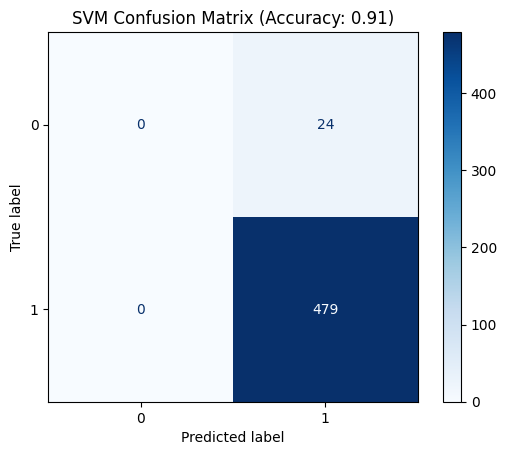

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"SVM Confusion Matrix (Accuracy: {grid.score(X_train, y_train):.2f})")
plt.show()

C:\Users\user\anaconda3\envs\torch-gpu\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


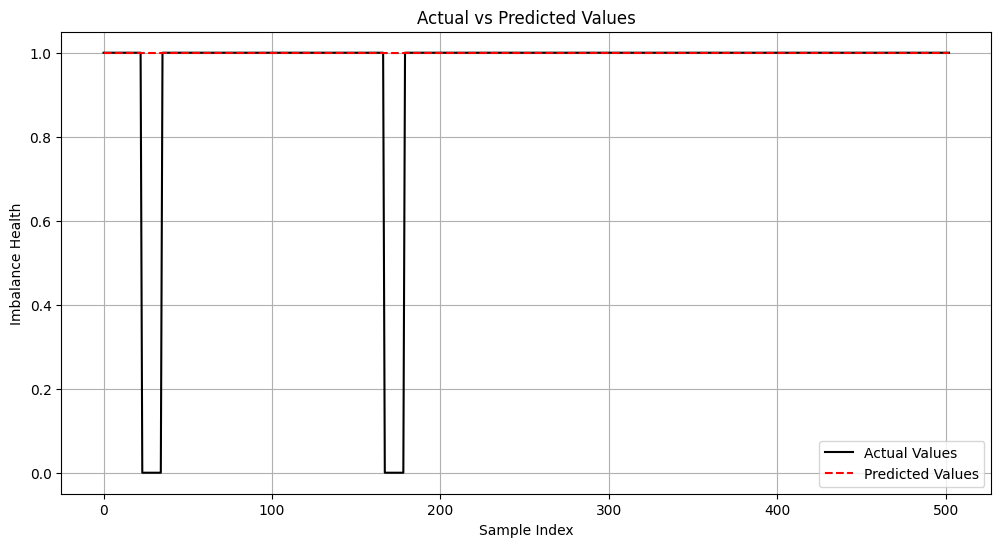

In [24]:
# 예측값 생성
x_range = np.linspace(data.min(), data.max(), 100).reshape(-1, X_train.shape[1])
predicted = grid.predict(x_range)

# 예측값과 실제값을 비교하기 위한 데이터프레임 생성
results = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred}).reset_index(drop=True)

# 시각화를 위한 x 값 생성 (테스트 데이터의 인덱스를 사용할 수 있음)
plt.figure(figsize=(12, 6))
plt.plot(results['Actual'].values, color='black', label='Actual Values')
plt.plot(results['Predicted'].values, color='red', linestyle='--', label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Imbalance Health')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()